---
# Inference

In [1]:
import os
import cv2
import torch
import rasterio
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def mask_image(
    model_path: str,
    input_image_path: str,
    DEVICE: str = "cuda",
    plot_result: bool = False,
):
    # Empty cache to avoid CUDA memory allocation error
    torch.cuda.empty_cache()

    # Move the model to the GPU
    model = torch.load(model_path, map_location=DEVICE)
    model = model.to(DEVICE)
    model.eval()

    # Open the TIFF image and apply necessary transformations
    input_image = Image.open(input_image_path)
    input_image = input_image.convert('RGB')  # Convert to RGB if the image has multiple channels

    # Calculate the desired padded shape
    desired_height = ((input_image.height - 1) // 32 + 1) * 32
    desired_width = ((input_image.width - 1) // 32 + 1) * 32

    # Pad the image to the desired shape
    padded_image = ImageOps.pad(input_image, (desired_width, desired_height))

    # Apply transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet mean and std
    ])

    # Perform inference on 512x512 windows
    num_windows_height = (desired_height - 1) // 512 + 1
    num_windows_width = (desired_width - 1) // 512 + 1

    # Create an empty stitched mask
    stitched_mask = np.zeros((desired_height, desired_width))

    # Iterate over each window
    for i in range(num_windows_height):
        for j in range(num_windows_width):
            # Calculate the window coordinates
            y_start = i * 512
            y_end = min((i + 1) * 512, desired_height)
            x_start = j * 512
            x_end = min((j + 1) * 512, desired_width)

            # Extract the window from the padded image
            window_image = padded_image.crop((x_start, y_start, x_end, y_end))

            # Apply transformations
            input_tensor = transform(window_image)
            input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

            # Move the input tensor to the GPU
            input_tensor = input_tensor.to(DEVICE)

            # Perform inference on the window
            with torch.no_grad():
                output = model(input_tensor)

            # Move the output tensor to the CPU
            output = output.cpu().numpy()

            # Convert the output array to probabilities using softmax
            probabilities = torch.softmax(torch.from_numpy(output), dim=1)

            # Get the predicted class labels by finding the maximum probability for each pixel
            predicted_labels = torch.argmax(probabilities, dim=1)[0]

            # Copy the predicted labels to the stitched mask
            stitched_mask[y_start:y_end, x_start:x_end] = predicted_labels.cpu().numpy()

    if plot_result:
        plt.figure(figsize=(25,25))
        # Display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(input_image)
        plt.axis('off')
        plt.title('Input Image')

        # Display the stitched mask
        plt.subplot(1, 3, 2)
        plt.imshow(stitched_mask)
        plt.axis('off')
        plt.title('Stitched Mask')

    return stitched_mask


/home/ibrahim/anaconda3/envs/seg_pytorch/lib/python3.9/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (90710790 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


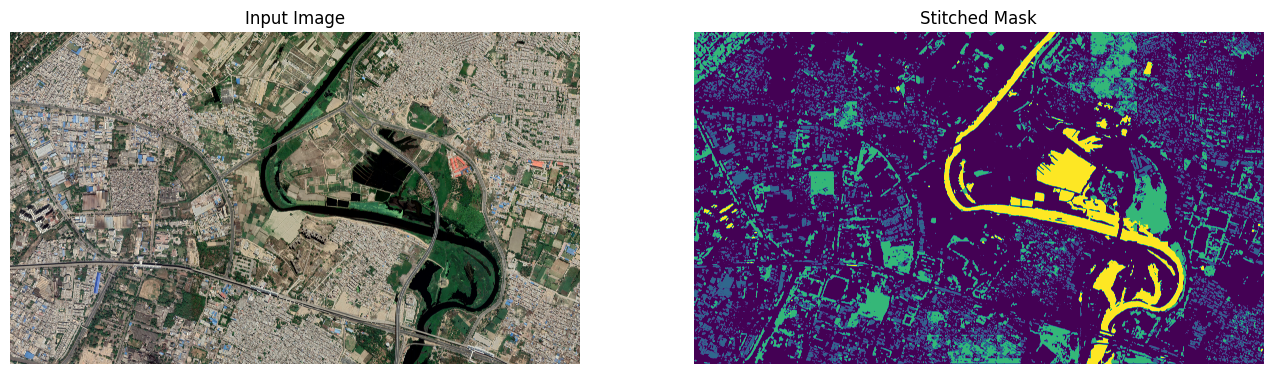

In [6]:
# Define path to files
model_path = "/home/ibrahim/Documents/Ibrahim_/July/lulc_dl/models/landcover_unet_efficientnet-b0_epochs18_patch512_batch16.pth"
input_image_path = "/home/ibrahim/Documents/Ibrahim_/July/lulc_dl/data/gaziabad_1.tif"

# Call the function
mask = mask_image(model_path= model_path,
           input_image_path=input_image_path,
           plot_result=True)

In [7]:
# Save the file (Experimental) 

""" 
The code works but to view the different colours in QGIS you'd have to 
do the following steps:

Layer -> Symbology -> Paletted/Unique Values -> Classify -> Confirm

 """

mask_3bands = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
mask_3bands_uint8 = (mask_3bands * 255).astype(np.uint8)  # Convert to uint8
cv2.imwrite('mask.tif', mask_3bands_uint8)

with rasterio.open(input_image_path) as src:
    profile = src.profile
    profile.update(dtype='uint8', count=3)

    with rasterio.open('mask.tif', 'w', **profile) as dst:
        dst.write(mask_3bands_uint8.transpose(2, 0, 1))